In [1]:
import os
import datetime
from pathlib import Path
from covid_graphs.country_report import CountryReport, create_report
from pprint import pprint
from covid_graphs.formula import  FittedFormula,BootstrappedFittedFormula,Formula,TraceGenerator
from covid_graphs.predictions import CountryPrediction, PredictionEvent, prediction_db
from typing import List, Tuple
from dataclasses import dataclass
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,max_error,median_absolute_error
from sklearn.preprocessing import StandardScaler  
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#data_dir=Path("../data/raw") # old 23 countries
data_dir=Path("../data/external") # new countries
countries=[x.replace(".data","") for x in os.listdir(data_dir) if x!=".gitkeep" and x!='download_all.zsh']

In [3]:
def _get_fitted_predictions(report: CountryReport,n=4,bootstrap=False) -> List[CountryPrediction]:
    def formula(until_date):
        if bootstrap:
            return BootstrappedFittedFormula(until_date=until_date)
        else:
             return FittedFormula(until_date=until_date)
        
    return [
        CountryPrediction(
            prediction_event=PredictionEvent(
                name=f"daily_fit_{until_date.strftime('%Y_%m_%d')}", date=until_date
            ),
            country=report.short_name,
            formula=formula(until_date),
        )
        for until_date in [report.dates[-x] for x in range(1,n+1)]
    ]

In [25]:
def download_new_data():
    import pandas as pd
    url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    table = pd.read_csv(url)
    import os
    import sys
    from covid_graphs.prepare_data import main as prp_data
    for country in set(table["Country/Region"].tolist()):
        if country!="Taiwan*":
            continue
        f=os.getcwd()
        try:
            os.chdir("../data/external")
            sys.argv=["C",country,"--short_name",country.replace("*","")]
            prp_data()
        finally:
            os.chdir(f)        

# !!! uncoment to download data !!!
# download_new_data()
    


In [20]:
# os.chdir(r"C:\projects\covid\COVID-19-simulation\covid_graphs\covid_fitting\notebooks")

In [9]:
def train_date(country_prediction):
    return country_prediction.prediction_event.date
def get_end_date(report):
    return report.dates[-1]
day=datetime.timedelta(days=1)
@dataclass
class Model:
    formula: Formula
    curve: TraceGenerator
    report: CountryReport
    name:str
    def get_fit(self):
        return self.formula.fit
    def inflexion_date(self):
        #TODO: cannot be done
        return self.curve.start_date+datetime.timespace(days=floor(ib))
        
    def start_date(self):
        return self.curve.start_date
    
    def x(self, date):
        return (date-self.curve.start_date).days
        
        
    def y_test(self, date):
        for i,d in enumerate(self.report.dates):
            if d==date:
                return self.report.cumulative_active[i]
        return self.report.cumulative_active[-1]
        
    def y_predict(self, date):
        if date<self.start_date():
            return 0
        x=self.x(date)
        
        return self.curve.func(x)
        
    def eval(self, start_from: datetime.date, to: datetime.date):
        #print("Evaluating")
        #assert start_from>=self.start_date()
        predict=[]
        test=[]
        
        #xs,ys= self.curve.generate_trace(to)
        #for a1,a2 in zip(xs,ys):
        #    print(self.name, a1,a2)
        #print("me start date",self.name, self.start_date())
        for i in range((to-start_from).days+1 ):
            date=start_from+datetime.timedelta(days=i)
            #print("me",self.name,date, self.x(date),self.y_test(date),self.y_predict(date))
            test.append(self.y_test(date))
            predict.append(self.y_predict(date))        
        return np.array(test),np.array(predict)
            
            
def model(cp: CountryPrediction, report:CountryReport,name:str):
    formula = cp.formula
                   
    curve =formula.get_trace_generator(report)

    return Model(formula, curve, report,name)
    
@dataclass    
class ModelMetrics():
    mse: float
    mre:float
    medre:float
        
@dataclass 
class  ModelReport():
    our_train_until:datetime.date
    eval_from:datetime.date
    rk:ModelMetrics
    our:ModelMetrics
        
def metrics(y_true,y_pred):
    
#     relative_difference=np.maximum(
#                 y_pred/y_true,
#                 y_true/y_pred )
    relative_difference=(y_pred-y_true)/y_true 
    
    return ModelMetrics(
        mean_squared_error(
            y_true, 
            y_pred),
        
        mean_absolute_error(
            np.zeros(len(y_true)), 
            relative_difference ),
         median_absolute_error(
            np.zeros(len(y_true)), 
            relative_difference )
    )
def dd(a,b):
    return (a-b).days

def get_points(a:CountryPrediction,report:CountryReport):
    start_date = report.dates[0]
    last_fit_date =train_date(a)
    last_known_date = report.dates[-1]
    #end_date = get_end_date(report)
    
    ma=model(a, report,'our')
#fit:
#       a: float
#     tg: float
#     exp: float
#     t0: float
    fit = ma.get_fit()
    tg=fit.tg
    alfa= fit.exp
    t0=fit.t0
    A=fit.a
    
    maximumpoint=alfa*tg+t0
    maximum_value=fit.predict(maximumpoint)
    
    inflexion_point_1= (tg*(alfa-np.sqrt(alfa))  +t0)
    inflexion_point_2= (tg*(alfa+np.sqrt(alfa))  +t0)
    inflexion_value_1=fit.predict(inflexion_point_1)
    inflexion_value_2=fit.predict(inflexion_point_2)
    
    return (maximumpoint,maximum_value,
           inflexion_point_1,inflexion_value_1,
           inflexion_point_2,inflexion_value_2)
    
    end_date=ma.curve.display_at_least_until

    yt, ya = ma.eval(start_date, end_date)
    last_date=report.dates[-1]

    

    return  (
        yt,ya,
        dd(last_fit_date, start_date),
        dd(last_known_date, start_date)        
    )
    
def get_all_data(a:CountryPrediction,report:CountryReport):
    start_date = report.dates[0]
    last_fit_date =train_date(a)
    last_known_date = report.dates[-1]
    #end_date = get_end_date(report)
    
    ma=model(a, report,'our')
    #print(ma.get_fit())
    end_date=ma.curve.display_at_least_until

    yt, ya = ma.eval(start_date, end_date)
    last_date=report.dates[-1]

    
    return  (
        yt,ya,
        dd(last_fit_date, start_date),
        dd(last_known_date, start_date)        
    )
      


#compare_predictions(country_predictions[1],country_predictions[3],country_report)

    

def graph_for_country(country_name, show_data=False, each=False,n=7,skip=0,bootstrap=False):
    
    country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
    fitted_predictions=_get_fitted_predictions(report=country_report,n=n,bootstrap=bootstrap)  
        
    c="rgbcmykkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk"
    for i in range(len(fitted_predictions)):
        if i<skip:
            continue
        prediction=fitted_predictions[i]
        yt,y,n_train,n_known=get_all_data(prediction, country_report)
        plt.plot(y,c[i])
        if show_data:
            plt.plot(yt,'o')
            show_data=False
        if each:
            plt.show()

    if not each:
        plt.show()
        
def graph_for_country_with_bootstrap(country_name, show_data=False, each=False,n=7,skip=0):
    
    country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
    fitted_predictions=_get_fitted_predictions(report=country_report,n=n,bootstrap=False)  
    fitted_predictions_bs=_get_fitted_predictions(report=country_report,n=n,bootstrap=True)  
        
    c="rgbcmykkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk"
    for i in range(len(fitted_predictions)):
        if i<skip:
            continue
        prediction=fitted_predictions[i]
        yt,y,n_train,n_known=get_all_data(prediction, country_report)
        if show_data:
            plt.plot(yt,'o')
            show_data=False
            
        plt.plot(y,c[i])
        prediction=fitted_predictions_bs[i]
        yt,y,n_train,n_known=get_all_data(prediction, country_report)
        plt.plot(y,c[i]+":")
        if each:
            plt.show()

    if not each:
        plt.show()        
        
def graph_for_country_orig(country_name, show_data=False, each=False):
    
    country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
    fitted_predictions=prediction_db.predictions_for_country(country=country_name)    
        
    c="rgbcmykkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk"
    for i in range(len(fitted_predictions)):
        
        prediction=fitted_predictions[i]
        yt,y,n_train,n_known=get_all_data(prediction, country_report)
        plt.plot(y,c[i])
        if show_data:
            plt.plot(yt,'o')
            show_data=False
        if each:
            plt.show()

    if not each:
        plt.show()        
        
        
  

def points_for_country(country_name,n=5):
    # prints explained variance on fit data
    country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
    fitted_predictions=_get_fitted_predictions(report=country_report,n=n)
    
    for i in range(len(fitted_predictions)):           
        prediction=fitted_predictions[i]
        (maximumpoint,maximum_value,
           inflexion_point_1,inflexion_value_1,
           inflexion_point_2,inflexion_value_2)=get_points(prediction, country_report)
        
        print("{}  {:4.3f} {:4.3f}".format(
            prediction.prediction_event.date, 
            maximumpoint,
            maximum_value,            
            ))
        print("{}                        {:4.3f} {:4.3f} {:4.3f} {:4.3f}".format(
        prediction.prediction_event.date, 

        inflexion_point_1,
        inflexion_value_1,
        inflexion_point_2,
        inflexion_value_2
        ))
        #print("{} percent explained = {:.3f}".format(prediction.prediction_event.date, (1-mean_squared_error(yt,y))*100))
def compare_predictions(a:CountryPrediction,b:CountryPrediction,report:CountryReport):
    start_date = report.dates[0]
    #last_fit_date =train_date(a)
    #last_known_date = report.dates[-1]
    #last_date=report.dates[-1]
    #end_date = get_end_date(report)
   
  
    ma=model(a, report,'model_a')
    mb=model(b, report,'model_b')
             
    end_date=max(ma.curve.display_at_least_until,
                 mb.curve.display_at_least_until)
    
    yt, ya=ma.eval(start_date, end_date)
    yt2, yb=mb.eval(start_date, end_date)
    sum1=0
    sum2=0
    fit1=ma.get_fit().predict
    fit2=mb.get_fit().predict
    for i in range(len(ya)-1):
        d=10
        for dt in range(d):
            x=i+dt/d
            f1=fit1(x)
            f2=fit2(x)
            sum1+=np.abs(f1-f2)/d
            sum2+=(f1+f2)/d
        
    assert(np.array_equal(yt,yt2))
    return (sum1, sum1/(sum2-sum1))
 
def fit_for_country(country_name, log=False,n=7):
    # prints explained variance on fit data
    country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
    fitted_predictions=_get_fitted_predictions(report=country_report,n=n)
    
    for i in range(len(fitted_predictions)):           
        prediction=fitted_predictions[i]
        yt,y,n_train,n_known=get_all_data(prediction, country_report)
        y=y[:n_train].reshape([-1,1])
        yt=yt[:n_train].reshape([-1,1])
        if log:
            y=np.log(y+1)
            yt=np.log(yt+1)
        
        T=StandardScaler()
        yt=T.fit_transform(yt)
        y=T.transform(y)
        print("{} percent explained{} = {:.3f}".format(
            prediction.prediction_event.date, 
            '(log)' if log else '', 
            (1-mean_squared_error(yt,y))*100))

def curvedif_country(country_name, n=3):
    # prints explained variance on fit data
    country_report = create_report(data_dir / f"{country_name}.data", short_name=country_name)
    fitted_predictions=_get_fitted_predictions(report=country_report,n=n)
    
    #for i in range(len(fitted_predictions)):           
    prediction=fitted_predictions[0]
    prediction2=fitted_predictions[n-1]
    area, normalized_area=compare_predictions(prediction, prediction2, country_report)        
    print("{} area = {:3.5f} {:7.5}".format(
        prediction.prediction_event.date,             
       normalized_area, area))
        
#curvedif_country("USA")

#TODO: maximus, explained variance, difference of curves, get more countries

In [65]:
for country in stable:
    print()
    print(country)
    
    curvedif_country(country)


Vietnam
2020-04-30 area = 0.00386  28.367

Finland
2020-04-30 area = 0.00926  1350.0

Uganda
2020-04-30 area = 0.00817  17.106

Iceland
2020-04-27 area = 0.00101  46.421

Greece
2020-04-30 area = 0.01803  2905.3

Kyrgyzstan
2020-04-30 area = 0.00466  84.842

Timor-Leste
2020-04-30 area = 0.06985  44.967

Estonia
2020-04-30 area = 0.00962  1314.0

Turkey
2020-04-30 area = 0.01750 8.3776e+04

Uzbekistan
2020-04-30 area = 0.00068  35.664

Liberia
2020-04-30 area = 0.00464  19.228

Trinidad and Tobago
2020-04-30 area = 0.00571  29.989

Jordan
2020-04-27 area = 0.00266  27.999

Israel
2020-04-30 area = 0.00196  1167.4

Tunisia
2020-04-30 area = 0.00192  100.56

Czechia
2020-04-27 area = 0.00531  1827.6

Portugal
2020-04-30 area = 0.00916 2.504e+04

Latvia
2020-04-30 area = 0.00120  52.037

Madagascar
2020-04-30 area = 0.00507  21.538

Thailand
2020-04-30 area = 0.00027  16.814

Taiwan
2020-04-30 area = 0.00063  10.639

Luxembourg
2020-04-30 area = 0.00697  984.62

Croatia
2020-04-27 area =

In [66]:
for country in unstable:
    print()
    print(country)
    
    curvedif_country(country)


Belgium
2020-04-27 area = 0.00638 3.149e+04

Slovakia
2020-04-17 area = 0.11099 1.4786e+04

Chile
2020-04-30 area = 0.08237 6.1138e+04

Ukraine
2020-04-30 area = 0.05674 1.1593e+05

Peru
2020-04-30 area = 0.21061 4.5926e+11

Moldova
2020-04-30 area = 0.03224  7579.8

Bahamas
2020-04-30 area = 0.08897  576.32

Malawi
2020-04-30 area = 0.54533 7.4714e+07

Bangladesh
2020-04-30 area = 0.72065 7.6284e+05

Haiti
2020-04-30 area = 3.21506 3.5188e+04

South Africa
2020-04-30 area = 0.45945 2.3523e+10

Bulgaria
2020-04-30 area = 0.14262 8.0269e+08

Zimbabwe
2020-04-30 area = 0.04990  200.16

Maldives


c:\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: divide by zero encountered in double_scalars


2020-04-30 area = inf 2.1507e+25

Ecuador
2020-04-30 area = 3.87514 6.5608e+13

Norway
2020-04-27 area = 0.01271 1.0303e+04

Jamaica
2020-04-30 area = 3.48371 6.5679e+12

Armenia
2020-04-30 area = 0.09527  9690.4

Netherlands
2020-04-27 area = 0.02206 1.3588e+05

Kosovo
2020-04-30 area = 0.29422 1.8511e+04

USA
2020-04-30 area = 0.00649 1.0142e+06

Philippines
2020-04-30 area = 0.06955 8.9866e+04

Canada
2020-04-27 area = 0.12850 4.4971e+06

Libya
2020-04-30 area = 0.02843  89.855

Somalia
2020-04-30 area = 0.06130  3251.3

Pakistan
2020-04-30 area = 0.09249 3.0431e+08

Mali
2020-04-30 area = 0.22609 4.5029e+04

Sweden
2020-04-30 area = 0.09959 3.5055e+05

Bolivia
2020-04-30 area = 6.82198 4.4132e+08

Algeria
2020-04-30 area = 0.38062 1.1648e+05

Oman
2020-04-30 area = 0.23449 1.1461e+05

Yemen
2020-04-30 area = 6639684340.44411 2.03e+13

Papua New Guinea
2020-04-30 area = 0.02201  9.2371

Nepal
2020-04-30 area = 0.03309  96.365

Cameroon
2020-04-30 area = 0.02720  1551.9

Japan
2020-0

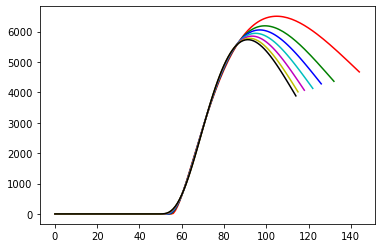

In [67]:
graph_for_country("Chile",False, False)

In [21]:
for country in unstable:
    if country=="Zambia":
        continue
    print(country)
    graph_for_country(country,n=3)

NameError: name 'unstable' is not defined

In [12]:
for country in unstable:
    print()
    print(country)
    points_for_country(country)


UK
2020-04-27  113.166 163288.934
2020-04-27                        82.550 79659.997 143.781 110517.534
2020-04-26  111.373 158532.504
2020-04-26                        82.270 78470.017 140.477 106893.881
2020-04-25  109.547 153605.375
2020-04-25                        81.970 77189.734 137.124 103134.693
2020-04-24  107.808 148837.627
2020-04-24                        81.669 75904.063 133.947 99490.923
2020-04-23  106.154 144224.024
2020-04-23                        81.368 74613.046 130.940 95959.252

France
2020-04-27  99.200 100630.864
2020-04-27                        74.803 53260.090 123.596 66409.187
2020-04-26  100.237 102434.029
2020-04-26                        75.059 53928.170 125.414 67734.068
2020-04-25  99.813 103440.189
2020-04-25                        75.885 56152.396 123.742 67554.325
2020-04-24  101.818 108018.343
2020-04-24                        76.742 58512.565 126.894 70610.622
2020-04-23  109.314 122960.455
2020-04-23                        78.465 63519.050 140.1

2020-04-28  103.380 43.793
2020-04-28                        86.202 23.654 120.558 28.663
2020-04-27  106.883 49.250
2020-04-27                        87.953 26.746 125.812 32.158
2020-04-26  127.712 93.314
2020-04-26                        97.921 49.187 157.502 61.676

Bahamas
2020-04-30  104.550 48.637
2020-04-30                        73.150 21.010 135.949 33.709
2020-04-29  108.547 50.852
2020-04-29                        72.889 20.629 144.205 35.545
2020-04-28  113.213 53.615
2020-04-28                        72.800 20.484 153.627 37.722
2020-04-27  120.664 58.253
2020-04-27                        72.910 20.605 168.418 41.264
2020-04-26  128.240 63.132
2020-04-26                        73.178 20.950 183.301 44.925

Venezuela
2020-04-30  104992.326 62562.649
2020-04-30                        -5888.503 0.000 215873.155 46321.441
2020-04-29  138435.951 62127.158
2020-04-29                        -10862.559 0.000 287734.460 46109.593
2020-04-28  198426.579 47049.525
2020-04-28        

2020-04-27  152.438 1129.818
2020-04-27                        110.961 582.798 193.916 752.457
2020-04-26  146.504 1072.387
2020-04-26                        109.717 568.856 183.290 707.085

Papua New Guinea
2020-04-30  96.232 8.238
2020-04-30                        83.921 4.477 108.544 5.377
2020-04-29  96.356 8.254
2020-04-29                        83.934 4.482 108.778 5.390
2020-04-28  97.076 8.374
2020-04-28                        84.039 4.525 110.114 5.480
2020-04-27  100.837 9.139
2020-04-27                        84.993 4.888 116.680 6.006
2020-04-26  158.972 42.651
2020-04-26                        114.051 22.269 203.893 28.288

Yemen
2020-04-30  3108.823 3690500498.145
2020-04-30                        2049.644 1919536609.302 4168.002 2450958771.717
2020-04-29  106.581 1.028
2020-04-29                        27.564 0.000 185.597 0.851
2020-04-28  81.959 0.761
2020-04-28                        35.364 0.000 128.554 0.712
2020-04-27  79.605 0.812
2020-04-27                       

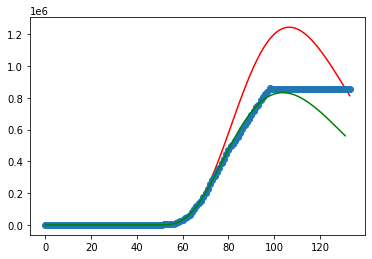

In [28]:
graph_for_country_orig("USA",True)

2020-06-22


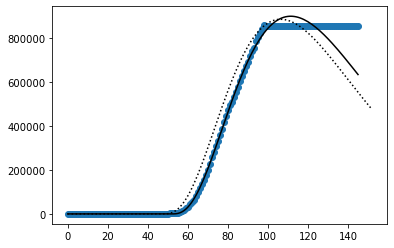

In [16]:
graph_for_country_with_bootstrap("USA",True,n=7, skip=6)

2020-05-12


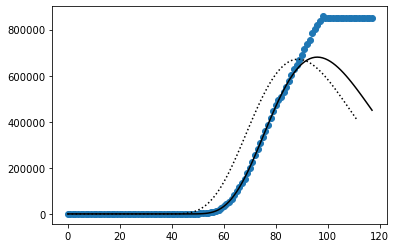

In [17]:
graph_for_country_with_bootstrap("USA",True,n=14, skip=13)

2020-07-11


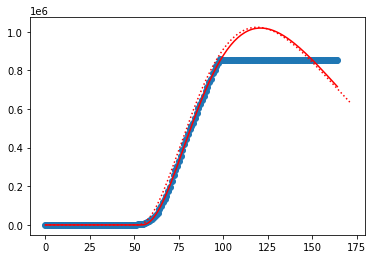

In [18]:
graph_for_country_with_bootstrap("USA",True,n=3, skip=0)

2020-07-08
2020-07-19
2020-07-13


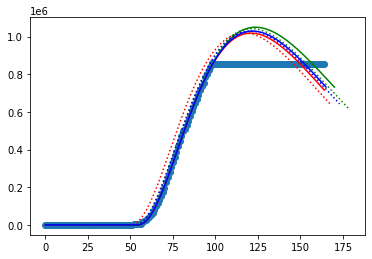

In [19]:
graph_for_country_with_bootstrap("USA",True,n=3, skip=0)

0 AtgModelFit(a=36409.894941644714, tg=8.557094379201958, exp=6.189811846921946, t0=43.852991540217715)
1 AtgModelFit(a=28387.600730042715, tg=8.406393138879857, exp=6.31436196670026, t0=43.579723962588034)
2 AtgModelFit(a=19601.968942707386, tg=8.122865855105111, exp=6.493294170516698, t0=43.35611746767043)
3 AtgModelFit(a=164335.79126639463, tg=9.605164928045383, exp=5.406316226188281, t0=45.81947935895976)
4 AtgModelFit(a=34945.41425630143, tg=8.466394382555345, exp=6.2026770264933475, t0=43.97219612021451)
5 AtgModelFit(a=70.23450218913058, tg=6.052836421219435, exp=9.068974536560829, t0=38.420231849615554)
6 AtgModelFit(a=132.01793042378608, tg=6.140032298010458, exp=8.782650951485943, t0=39.20523684954117)
7 AtgModelFit(a=100979.29397966746, tg=9.192766962897224, exp=5.659642889492873, t0=45.244581421884035)
8 AtgModelFit(a=1723.7843026259925, tg=6.910295013866203, exp=7.625228291427161, t0=41.314966956708304)
9 AtgModelFit(a=35207.19929082582, tg=8.390243967250118, exp=6.1886961

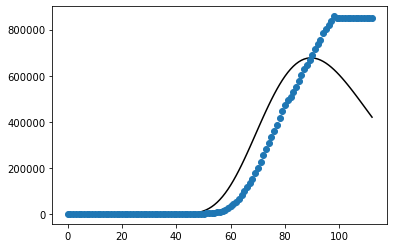

In [15]:
graph_for_country("USA",True,n=14, skip=13,orig=False)

In [31]:
countries

['Algeria',
 'Angola',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Barbados',
 'Bhutan',
 'Bolivia',
 'Brazil',
 'Bulgaria',
 'Cambodia',
 'Cameroon',
 'Central African Republic',
 'Chile',
 'Costa Rica',
 'Cyprus',
 'Diamond Princess',
 'Ecuador',
 'El Salvador',
 'Estonia',
 'Fiji',
 'Finland',
 'Gambia',
 'Georgia',
 'Germany',
 'Greece',
 'Haiti',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Kazakhstan',
 'Kosovo',
 'Kyrgyzstan',
 'Latvia',
 'Liberia',
 'Libya',
 'Liechtenstein',
 'Luxembourg',
 'Madagascar',
 'Malawi',
 'Malaysia',
 'Maldives',
 'Mali',
 'Moldova',
 'Monaco',
 'Namibia',
 'Nepal',
 'Nicaragua',
 'Oman',
 'Pakistan',
 'Papua New Guinea',
 'Peru',
 'Philippines',
 'Portugal',
 'Saint Lucia',
 'Sierra Leone',
 'Somalia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Tajikistan',
 'Tanzania',
 'Thailand',
 'Timor-Leste',
 'Togo',
 'Trinidad and Tobago',
 'Tunisia',
 'Turkey',
 'Uganda',
 'Ukraine',

In [11]:
# convert manual classification to data
def lin(z):
    return [x.strip() for x in z.split(',')]
exclude=set(lin(
    "Diamond Princess,Saint Lucia,Bhutan,Western Sahara, Gambia, Angola,Papua New Guinea"
)+lin(
"Tajikistan, Central African Republic, Zambia"  # problems
)
)


rep="""Australia
Austria
Azerbaijan
Barbados
Belgium
Cambodia
Costa Rica *
Cyprus *
Estonia **
Fiji *
Finland *
Germany
Greece *
Ireland *
Israel
Italy
Kyrgyzstan *
Latvia
Liberia *
Liechtenstein *
Luxembourg **
Madagascar
Malaysia
Monaco
Namibia
Netherlands
Nicaragua
Portugal *************
Spain *****
Switzerland
Taiwan
Thailand
Timor-Leste
Togo **
Trinidad and Tobago
Tunisia
Turkey ********
Uganda
Uruguay
Uzbekistan
Vietnam
Iceland
Jordan
Czechia
Croatia
West Bank and Gaza
Iran
Lithuania
Georgia
NZ
Korea"""
stable = set([x.strip('*').strip() for x in rep.split("\n")])
unstable =(set(countries)-stable)-exclude
print('stable:',len(stable),'unknown/unstable:',len(unstable),"excluded:",len(exclude))

stable: 51 unknown/unstable: 44 excluded: 9


In [47]:
print(stable)

{'Vietnam', 'Finland', 'Uganda', 'Iceland', 'Greece', 'Kyrgyzstan', 'Timor-Leste', 'Estonia', 'Turkey', 'Uzbekistan', 'Liberia', 'Trinidad and Tobago', 'Jordan', 'Israel', 'Tunisia', 'Czechia', 'Portugal', 'Latvia', 'Madagascar', 'Thailand', 'Taiwan', 'Luxembourg', 'Croatia', 'Fiji', 'Iran', 'Spain', 'Austria', 'Costa Rica', 'Monaco', 'Namibia', 'Georgia', 'Azerbaijan', 'Lithuania', 'Switzerland', 'NZ', 'Korea', 'Malaysia', 'Barbados', 'Uruguay', 'Cambodia', 'Ireland', 'Australia', 'Togo', 'Italy', 'Germany', 'Liechtenstein', 'Cyprus', 'Nicaragua', 'West Bank and Gaza'}
